In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [3]:
import matplotlib.pyplot as plt

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNEL_SIZE = 3
EPOCHS = 20

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
L = len(dataset)
L

68

In [8]:
type(dataset)

tensorflow.python.data.ops.batch_op._BatchDataset

In [9]:
for im, lb in dataset.take(1):
    print(im.shape)
    print(lb.numpy())

(32, 256, 256, 3)
[0 1 1 0 1 0 0 0 0 1 1 0 0 0 1 0 0 1 1 0 1 0 0 0 0 2 0 0 1 0 1 0]


(32, 256, 256, 3) -> 32 batch size, 256,256 image size ,3 channel(RGB)

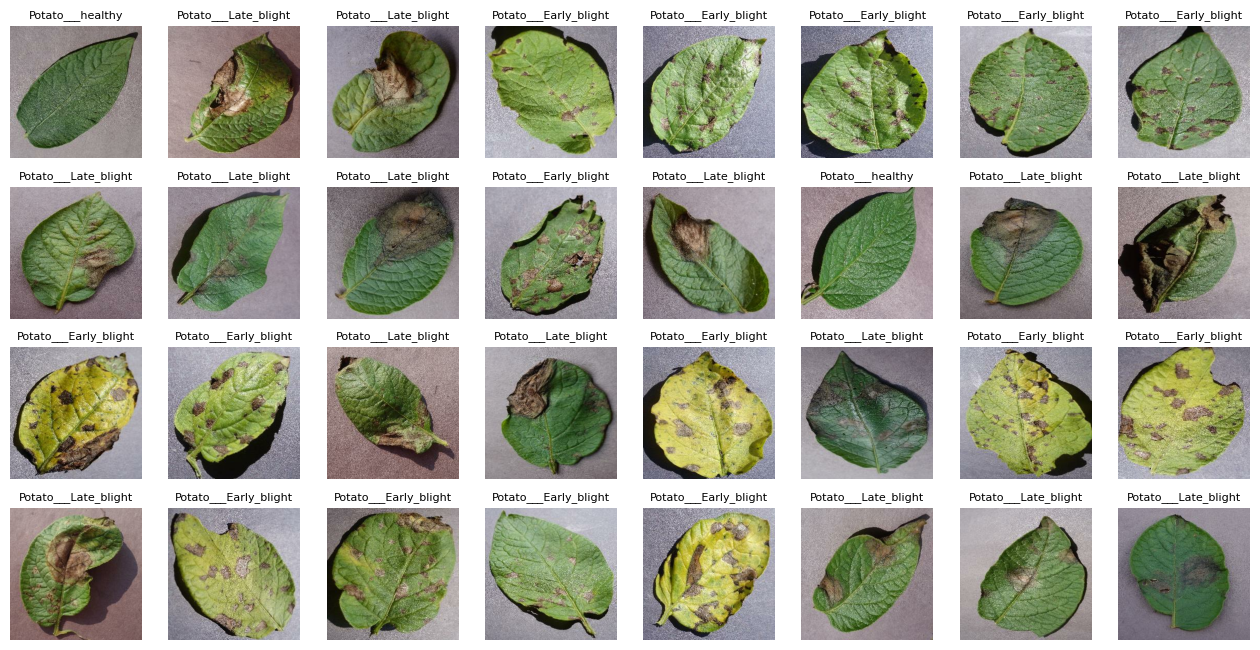

In [10]:
plt.figure(figsize=(16,8))
for im, lb in dataset.take(1):
    for i in range(32):
        ax = plt.subplot(4,8,i+1)
        plt.imshow(im[i].numpy().astype("uint8"))
        plt.title(class_name[lb[i]], fontsize=8)
        plt.axis("off")


100 dataset,
80 -> training
20 -> 10-validation, 10-testing

In [11]:
L

68

In [12]:
def data_split_function(dataset, train_size=0.8, test_size=0.1, val_size=0.1, shuffle=True, shuffle_size=3000):
    ds_size = len(dataset)
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=3)
    train_size = int(train_size*ds_size)
    val_size = int(val_size*ds_size)
    
    train_ds = dataset.take(train_size)

    val_ds = dataset.skip(train_size).take(val_size)

    test_ds = dataset.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [13]:
train_data, val_data, test_data = data_split_function(dataset)

In [14]:
len(train_data), len(val_data), len(test_data)

(54, 6, 8)

# preprocessing dataset

In [15]:
shfl=1000
train_data = train_data.cache().shuffle(shfl).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.cache().shuffle(shfl).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(shfl).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [17]:
data_augementation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomRotation(0.25),
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")
])

In [18]:
image_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL_SIZE)
n_classes = 3 #early,late,healthy

In [19]:
model = models.Sequential([
    resize_rescale,
    data_augementation,
    
    # LAYER-1
    layers.Conv2D(32, (3,3), activation="relu", input_shape=image_shape),
    layers.MaxPooling2D((2,2)),
    
    # LAYER-2
    layers.Conv2D(32, activation="relu", kernel_size=(3,3)),
    layers.MaxPooling2D((2,2)),
    
    # LAYER-3
    layers.Conv2D(32, activation="relu", kernel_size=(3,3)),
    layers.MaxPooling2D((2,2)),
   
    # LAYER-4
    layers.Conv2D(32, activation="relu", kernel_size=(3,3)),
    layers.MaxPooling2D((2,2)),
   
    # LAYER-5
    layers.Conv2D(32, activation="relu", kernel_size=(3,3)),
    layers.MaxPooling2D((2,2)),
   
    # flatten and dense
    layers.Flatten(),
    layers.Dense(32, activation="relu"),
    layers.Dense(n_classes, activation="softmax")
    
])

In [20]:
model.build(input_shape=image_shape)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 32)          0         
 g2D)                                                 

In [22]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [23]:
history = model.fit(
    train_data,
    epochs=10,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_data
)

Epoch 1/10


54/54 [==============================] - 253s 4s/step - loss: 0.8596 - accuracy: 0.5704 - val_loss: 0.7872 - val_accuracy: 0.6667
Epoch 2/10
54/54 [==============================] - 222s 4s/step - loss: 0.5577 - accuracy: 0.7940 - val_loss: 0.4999 - val_accuracy: 0.8281
Epoch 3/10
54/54 [==============================] - 219s 4s/step - loss: 0.4749 - accuracy: 0.8110 - val_loss: 0.3580 - val_accuracy: 0.8490
Epoch 4/10
54/54 [==============================] - 209s 4s/step - loss: 0.2628 - accuracy: 0.8944 - val_loss: 0.1574 - val_accuracy: 0.9479
Epoch 5/10
54/54 [==============================] - 199s 4s/step - loss: 0.2273 - accuracy: 0.9108 - val_loss: 0.4551 - val_accuracy: 0.8073
Epoch 6/10
54/54 [==============================] - 182s 3s/step - loss: 0.1926 - accuracy: 0.9313 - val_loss: 0.1510 - val_accuracy: 0.9271
Epoch 7/10
54/54 [==============================] - 167s 3s/step - loss: 0.0974 - accuracy: 0.9654 - val_loss: 0.1432 - val_accuracy: 0.9375
Epoch 8/10
54/54 [======

## plotting the history of model

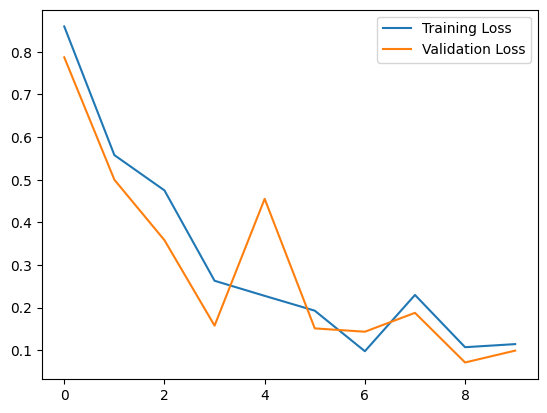

In [24]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show() 

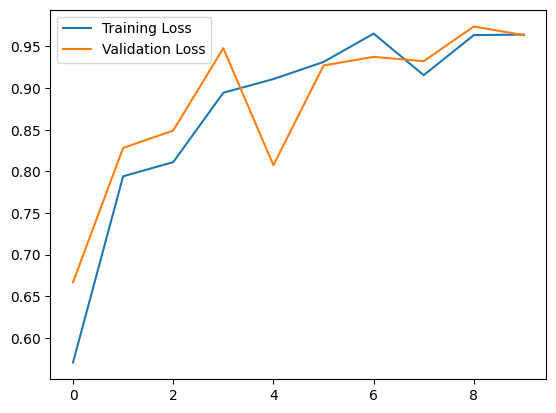

In [25]:
plt.plot(history.history['accuracy'], label='Training Loss')
plt.plot(history.history['val_accuracy'], label='Validation Loss')
plt.legend()
plt.show() 

first image to predict
actual label: Potato___Early_blight
predicted label: Potato___Early_blight


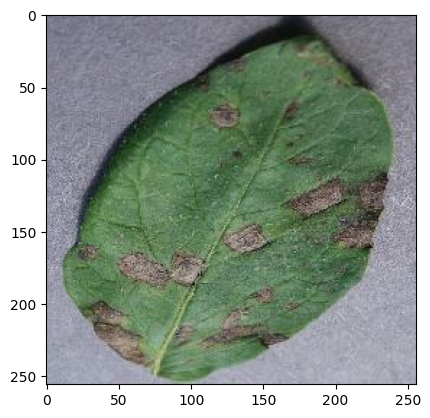

In [26]:
import numpy as np
for im, lb in test_data.take(1):
    
    first_image = im[0].numpy().astype('uint8')
    first_label = lb[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_name[first_label])
    
    batch_prediction = model.predict(im, verbose=0)
    print("predicted label:",class_name[np.argmax(batch_prediction[0])])

In [27]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(im[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 66ms/step


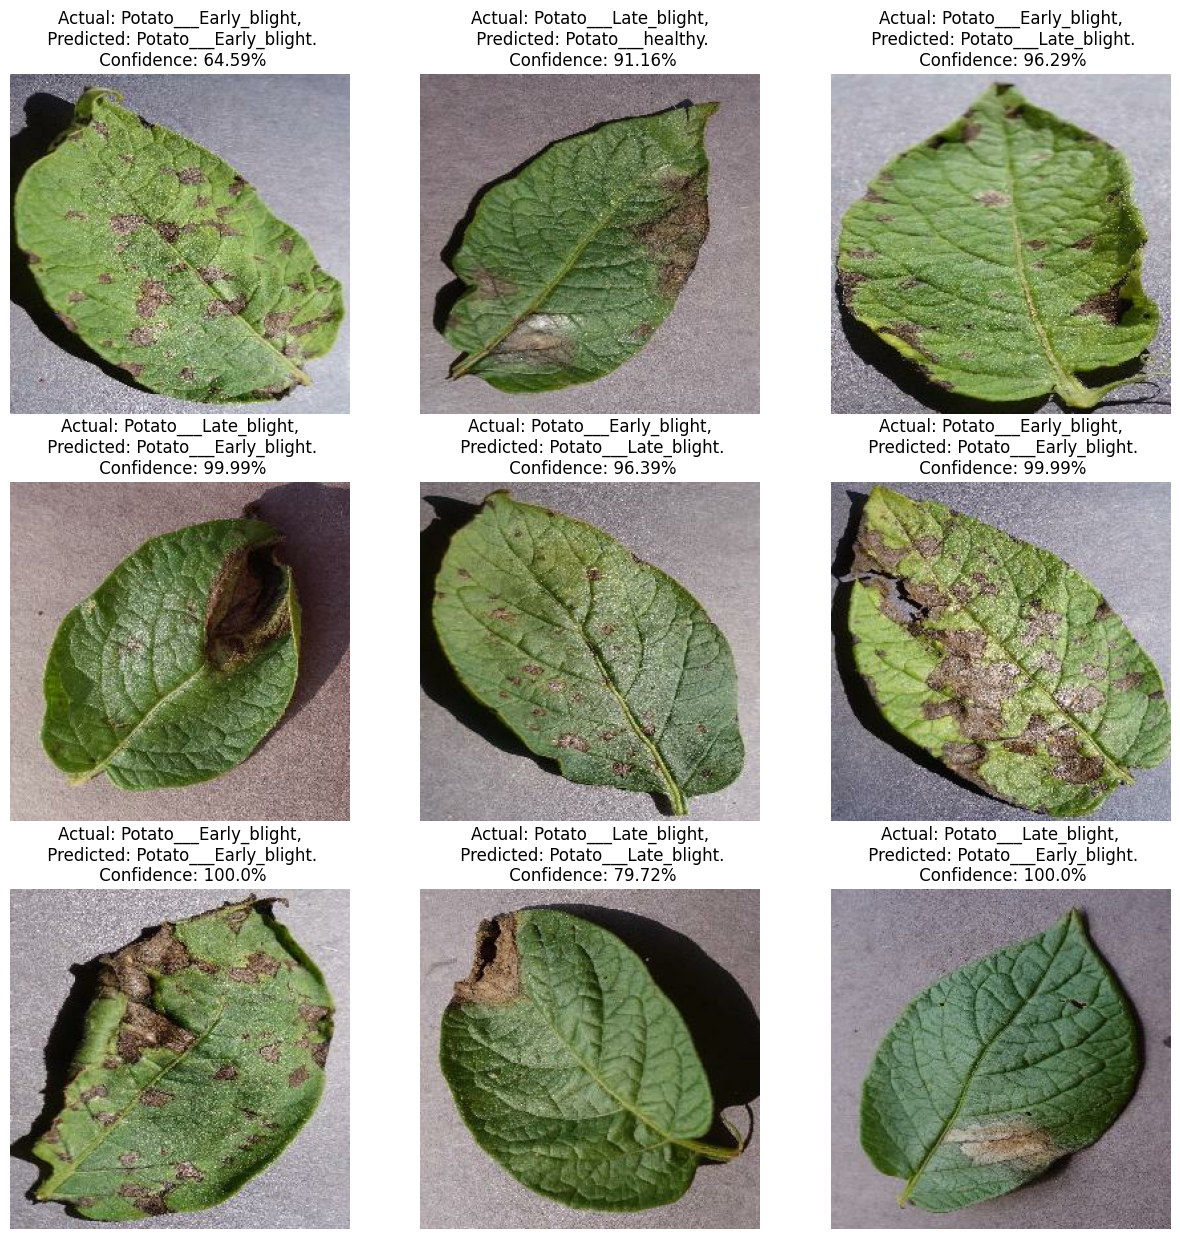

In [28]:
plt.figure(figsize=(15, 15))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

## saving the model

In [29]:
model_version = 2

In [30]:
model.save(f"Models/{model_version}")

INFO:tensorflow:Assets written to: Models/2\assets


INFO:tensorflow:Assets written to: Models/2\assets


In [31]:
model.save("Models/potatoes.h5")

c:\Users\chand\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
